In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,balanced_accuracy_score,log_loss
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
submission = pd.read_csv('submission.csv')

train_df.shape, test_df.shape, submission.shape

((21000, 17), (9000, 16), (9000, 1))

In [3]:
train_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y_bool
0,51,admin.,married,tertiary,no,148,no,no,cellular,15,apr,263,2,-1,0,unknown,0
1,55,blue-collar,married,secondary,no,7160,yes,no,unknown,4,may,315,1,-1,0,unknown,0
2,65,blue-collar,divorced,tertiary,no,2197,yes,no,cellular,12,may,102,2,-1,0,unknown,0
3,25,admin.,married,secondary,no,6658,yes,no,cellular,16,feb,197,1,-1,0,unknown,1
4,36,services,married,secondary,no,1761,yes,no,cellular,19,sep,177,1,-1,0,success,0


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        21000 non-null  int64 
 1   job        21000 non-null  object
 2   marital    21000 non-null  object
 3   education  21000 non-null  object
 4   default    21000 non-null  object
 5   balance    21000 non-null  int64 
 6   housing    21000 non-null  object
 7   loan       21000 non-null  object
 8   contact    21000 non-null  object
 9   day        21000 non-null  int64 
 10  month      21000 non-null  object
 11  duration   21000 non-null  int64 
 12  campaign   21000 non-null  int64 
 13  pdays      21000 non-null  int64 
 14  previous   21000 non-null  int64 
 15  poutcome   21000 non-null  object
 16  y_bool     21000 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 2.7+ MB


In [8]:
train_df.y_bool.value_counts()/len(train_df)

0    0.730905
1    0.269095
Name: y_bool, dtype: float64

In [9]:
train_df.describe()

,age,balance,day,duration,campaign,pdays,previous,y_bool
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,36.997952,1607.497810,11.056571,264.085048,2.013381,3.231952,0.102524,0.269095
std,10.484725,2991.187132,7.450415,288.163812,1.575916,23.161489,0.664355,0.443500
min,19.000000,-2072.000000,1.000000,4.000000,1.000000,-1.000000,0.000000,0.000000
25%,29.000000,299.000000,5.000000,94.000000,1.000000,-1.000000,0.000000,0.000000
50%,35.000000,633.000000,10.000000,184.000000,2.000000,-1.000000,0.000000,0.000000
75%,45.000000,1875.000000,16.000000,319.000000,2.000000,-1.000000,0.000000,1.000000
max,87.000000,71188.000000,31.000000,2703.000000,28.000000,437.000000,14.000000,1.000000


In [27]:
train_df['train_or_test']='train'
test_df['train_or_test']='test'
df=pd.concat([train_df,test_df])

In [28]:
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,poutcome,train_or_test
count,30000,30000,30000,30000,30000,30000,30000,30000,30000,30000
unique,12,3,4,2,2,2,3,12,4,2
top,blue-collar,married,secondary,no,yes,no,cellular,jul,unknown,train
freq,6990,19087,15204,28554,16071,23167,18727,7196,22907,21000


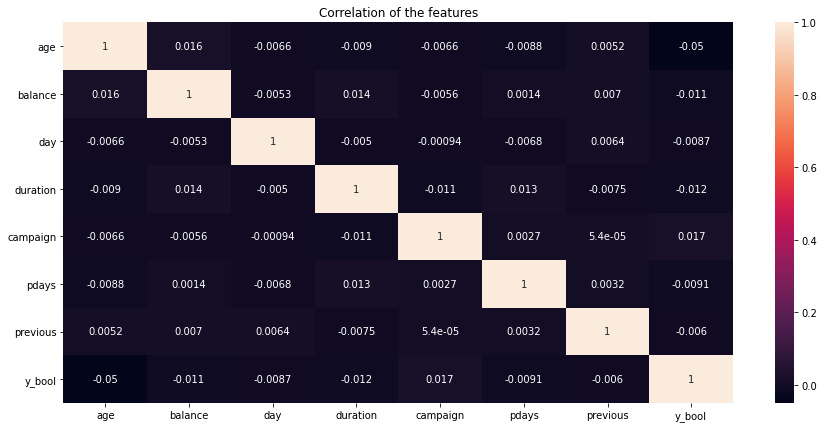

In [4]:
cor = train_df.iloc[:,:].corr()
plt.figure(figsize=(15,7))
sns.heatmap(cor, annot=True);
plt.title('Correlation of the features');

In [5]:
train_df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y_bool', 'train_or_test'],
      dtype='object')

In [11]:
cols = [ 'job', 'marital', 'education', 'default',  'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays','previous', 'poutcome']
for col in cols:
    print(pd.crosstab(train_df[col],train_df["y_bool"],normalize='index').round(2).T)

job     admin.  blue-collar  entrepreneur  housemaid  management  retired  \
y_bool                                                                      
0         0.74         0.72          0.69       0.67        0.72     0.73   
1         0.26         0.28          0.31       0.33        0.28     0.27   

job     self-employed  services  student  technician  unemployed  unknown  
y_bool                                                                     
0                0.72      0.74     0.73        0.74         0.7     0.78  
1                0.28      0.26     0.27        0.26         0.3     0.22  
marital  divorced  married  single
y_bool                            
0            0.73     0.73    0.74
1            0.27     0.27    0.26
education  primary  secondary  tertiary  unknown
y_bool                                          
0             0.73       0.73      0.73     0.74
1             0.27       0.27      0.27     0.26
default    no   yes
y_bool             
0        0.

In [29]:
from sklearn.preprocessing import KBinsDiscretizer
dics = KBinsDiscretizer(n_bins=5,strategy='quantile',encode='ordinal')
dics.fit(df[['age']])
df['age_rank'] = dics.transform(df[['age']])

def agegp(age):
    if age<31:
        return 'young'
    elif age<51:
        return 'middle'
    else:
        return 'senior'

df['age_group'] = df['age'].map(agegp)
##########################################################################
def jobtyp(job):
    if job in ['self-employed','housemaid','entrepreneur']:
        return 'self_employed'
    elif job in ['unknown','unemployed','student']:
        return 'unemployed'
    elif job in ['blue-collar','services']:
        return 'blue_collar'
    else:
        return job

df['job_type'] = df['job'].map(jobtyp)
#########################################################################
df['balance_pos']=df['balance'].apply(lambda x: 'yes' if x>0 else 'no')
disc_bal=KBinsDiscretizer(n_bins=10,strategy='quantile',encode='ordinal')
disc_bal.fit(df[['balance']])
df['balance_rank']=disc_bal.transform(df[['balance']])

def bal_range(bal):
    if bal<25:
        return 'low_bal'
    elif bal<500:
        return 'medium_bal'
    elif bal<2000:
        return 'high_bal'
    else:
        return 'very_high_bal'
    
df['bal_range']=df['balance'].map(bal_range)
###########################################################################
def week(day):
    if day<8:
        return 'Week1'
    elif day<15:
        return 'Week2'
    elif day<22:
        return 'Week3'
    else:
        return 'Week4'

df['week'] = df['day'].map(week)
############################################################################
df['duration'] = df['duration']/60
disc_dur=KBinsDiscretizer(n_bins=5,strategy='quantile',encode='ordinal')
disc_dur.fit(df[['duration']])
df['duration_rank']=disc_dur.transform(df[['duration']])
def call_time(time):
    if time<=1:
        return '<1min'
    elif time<=3:
        return '1-3min'
    elif time<=10:
        return '3-10min'
    else:
        return '>10 min'

df['call_dur'] = df['duration'].map(call_time)
#############################################################################
df['new_contact']=df['pdays'].apply(lambda x:'new_cust' if x==-1 else 'old_cust')
#################################################################################
def outlier_capping(df,col):

        q1=df[col].quantile(0.25)
        q3=df[col].quantile(0.75)
        iqr=q3-q1
        
        upper_whisker=q3 + 1.5 * iqr
        lower_whisker=q1- 1.5 * iqr
        
        df[col]=np.where(df[col]>upper_whisker,upper_whisker, #true action
                        np.where(df[col]<lower_whisker,lower_whisker,df[col]))
outlier_cols=['age','balance','duration','campaign']
for col in outlier_cols:
    outlier_capping(df,col)
#################################################################################
def frequency_encoding(column_name,output_column_name,df):
    fe_pol = (df.groupby(column_name).size()) / len(df)
    df[output_column_name] = df[column_name].apply(lambda x : fe_pol[x])
    
frequency_encoding('job','job_fe',df)
frequency_encoding('month','month_fe',df)
#################################################################################

pd.set_option('display.width', 200)
cat_var = ['job_type', 'marital', 'education','housing', 'loan', 'balance_pos','default',
           'contact', 'month','poutcome','age_group','bal_range', 'week','call_dur', 'new_contact']
df = pd.get_dummies(df, columns = cat_var, drop_first=True)
df.rename({'call_dur_3-10min': 'call_dur_3_10min', 'call_dur_<1min': 'call_dur_lt1min', 'call_dur_>10 min': 'call_dur_gt10 min'}, axis=1, inplace=True)
#################################################################################

train1=df[df.train_or_test=='train']
test1=df[df.train_or_test=='test']
train1.drop('train_or_test',axis=1,inplace=True)
test1.drop('train_or_test',axis=1,inplace=True)

#feat = ['age','job_type','marital','education','balance','housing',
#     'loan','contact','month','duration','campaign','poutcome',
#     'age_group','bal_range','week','call_dur','new_contact']

X = train1.copy()
X = X.drop(['y_bool','job'],axis=1)
y = train1['y_bool']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)

D:\Study\Great Lakes\INtro to python\Anaconda\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [30]:
#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=42)
X.info(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21000 entries, 0 to 20999
Data columns (total 55 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   age                      21000 non-null  float64
 1   balance                  21000 non-null  float64
 2   day                      21000 non-null  int64  
 3   duration                 21000 non-null  float64
 4   campaign                 21000 non-null  float64
 5   pdays                    21000 non-null  int64  
 6   previous                 21000 non-null  int64  
 7   age_rank                 21000 non-null  float64
 8   balance_rank             21000 non-null  float64
 9   duration_rank            21000 non-null  float64
 10  job_fe                   21000 non-null  float64
 11  month_fe                 21000 non-null  float64
 12  job_type_blue_collar     21000 non-null  uint8  
 13  job_type_management      21000 non-null  uint8  
 14  job_type_retired      

In [12]:
#Models which did not performe well have been commented out
from sklearn.linear_model import LogisticRegression
#from sklearn.naive_bayes import GaussianNB
#from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb

In [13]:
LR = LogisticRegression()
#GNB = GaussianNB()
#SVC = SVC()
DTC = DecisionTreeClassifier(random_state=0)
RFC = RandomForestClassifier(random_state=0)
ABC = AdaBoostClassifier(random_state=0)
GBC = GradientBoostingClassifier(random_state=0)
XGB = xgb.XGBClassifier(random_state=0)

In [14]:
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix,roc_curve,auc, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=6, random_state=9, shuffle=True)

In [21]:
y_train

1113     1.0
13421    0.0
17139    0.0
5026     0.0
373      0.0
        ... 
11284    0.0
11964    1.0
5390     0.0
860      1.0
15795    0.0
Name: y_bool, Length: 15750, dtype: float64

In [22]:
models = []
#models.append(("LogisticRegression", LR))
#models.append(("GaussianNB", GNB))
#models.append(("SVC", SVC))
models.append(("DecisionTreeClassifier", DTC))
models.append(("RandomForestClassifier", RFC))
models.append(("AdaBoostClassifier", ABC))
models.append(("GradientBoostingClassifier", GBC))
models.append(("XGBoostClassifier", XGB))


***************** DecisionTreeClassifier ******************

DecisionTreeClassifier(random_state=0)


Train Accuracy Score =  1.0




Test Accuracy Score =  0.6045714285714285


Macro F1 Score =  0.5044309754511683


Cross val score =  0.6021904761904762


roc_auc_score =  0.5051628080385663


log_loss_score = 13.657619008730396
Classification Report
               precision    recall  f1-score   support

         0.0       0.74      0.71      0.73      3883
         1.0       0.27      0.30      0.28      1367

    accuracy                           0.60      5250
   macro avg       0.50      0.51      0.50      5250
weighted avg       0.62      0.60      0.61      5250



Confusion Matrix 
[[2767 1116]
 [ 960  407]]


AxesSubplot(0.125,0.808774;0.62x0.0712264)



***************** RandomForestClassifier ******************

RandomForestClassifier(random_state=0)


Train Accuracy Score =  1.0




Test Accuracy Score =  0.733904761904762


Macro F1 Score =  0.4308330964472205


Cross va

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


Train Accuracy Score =  0.8156190476190476




Test Accuracy Score =  0.7209523809523809


Macro F1 Score =  0.4639973099686221


[12:36:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to '

C:\Users\Acer\AppData\Roaming\Python\Python37\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:36:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:36:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:36:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:36:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

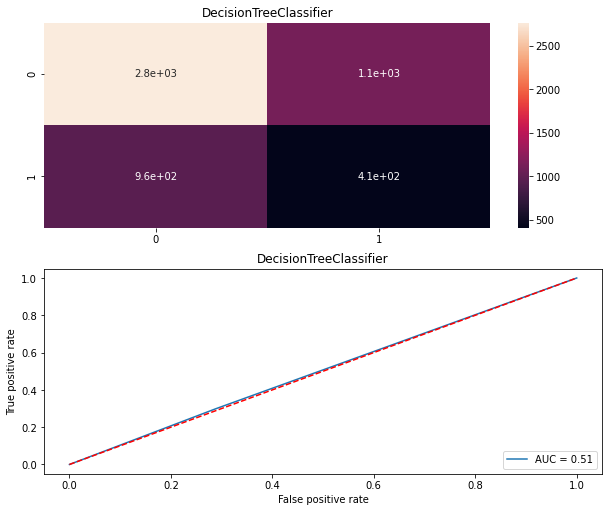

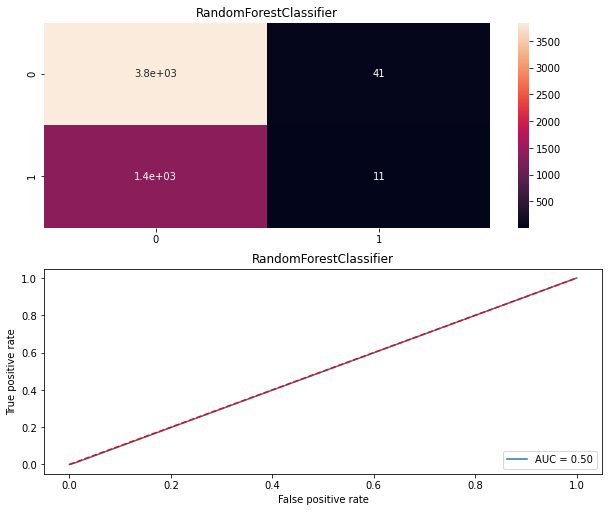

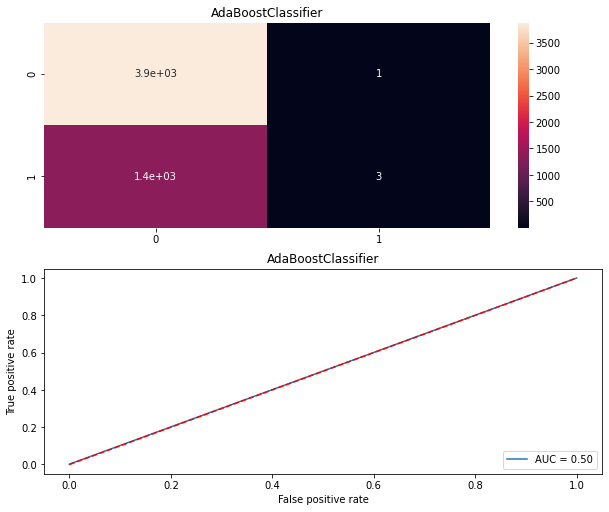

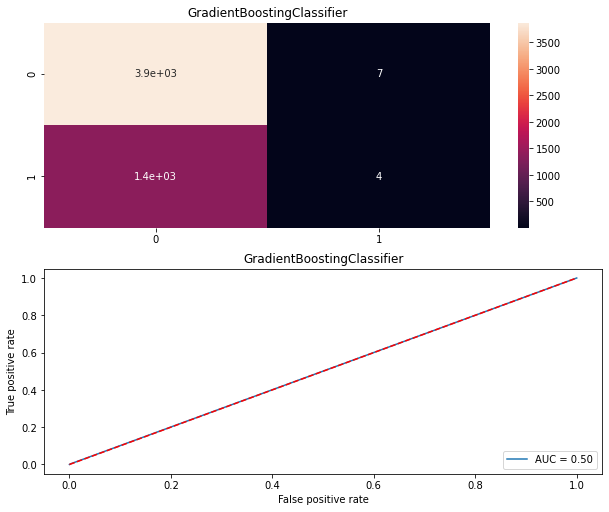

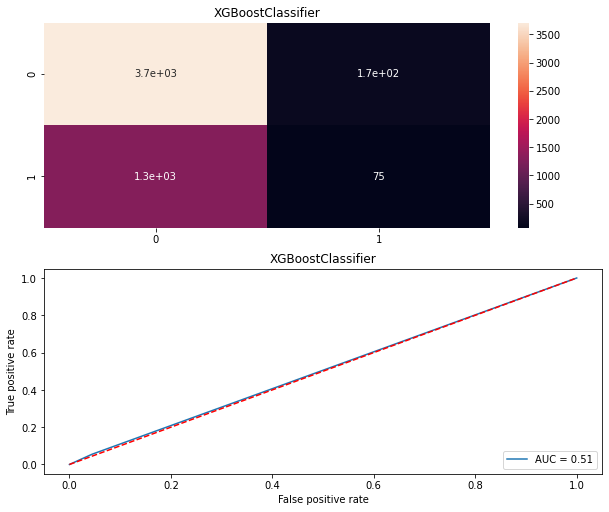

In [31]:
Model = []
train_score = []
test_score = []
f1_scores = []
cvs = []
rocscore = []
loglossscore = []
for name,model in models:
    print("*****************",name,"******************\n")
    Model.append(name)
    model.fit(X_train,y_train)
    print(model)
    train_pre = model.predict(X_train)
    print("\n")
    TAS = accuracy_score(y_train,train_pre)
    print("Train Accuracy Score = ",TAS)
    train_score.append(TAS*100)
    print("\n")
    pre = model.predict(X_test)
    print("\n")
    AS = accuracy_score(y_test,pre)
    print("Test Accuracy Score = ",AS)
    test_score.append(AS*100)
    print("\n")
    f1 = f1_score(y_test, pre, average='macro')
    print("Macro F1 Score = ",f1)
    f1_scores.append(f1)
    print("\n")
    sc = cross_val_score(model,X,y,cv=10,scoring="accuracy").mean()
    print("Cross val score = ",sc)
    cvs.append(sc*100)
    print("\n")
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test,pre)
    roc_auc = auc( false_positive_rate, true_positive_rate)
    print("roc_auc_score = ",roc_auc)
    rocscore.append(roc_auc*100)
    print("\n")
    clf_probs = model.predict_proba(X_test)
    score = log_loss(y_test, clf_probs)
    print("log_loss_score =",score)
    loglossscore.append(score)
    print("Classification Report\n", classification_report(y_test,pre))
    print("\n")
    cm = confusion_matrix(y_test,pre)
    print("Confusion Matrix \n{}".format(cm))
    print("\n")
    plt.figure(figsize = (10,40))
    plt.subplot(911)
    plt.title(name)
    print(sns.heatmap(cm,annot=True))
    plt.subplot(912)
    plt.title(name)
    plt.plot(false_positive_rate, true_positive_rate,label = "AUC = %0.2f"% roc_auc)
    plt.plot([0,1],[0,1],'r--')
    plt.legend(loc = 'lower right')
    plt.ylabel("True positive rate")
    plt.xlabel("False positive rate")
    print("\n\n")

In [32]:
result = pd.DataFrame({"Model": Model,"Training Accuracy": train_score,"Testing Accuracy": test_score, "Cross val score": cvs,"F1 Score": f1_scores,'ROC AUC Score': rocscore, 
                      "Log Loss score": loglossscore})
result

,Model,Training Accuracy,Testing Accuracy,Cross val score,F1 Score,ROC AUC Score,Log Loss score
0,DecisionTreeClassifier,100.000000,60.457143,60.219048,0.504431,50.516281,13.657619
1,RandomForestClassifier,100.000000,73.390476,72.838095,0.430833,49.874399,0.584012
2,AdaBoostClassifier,72.812698,74.000000,73.052381,0.427426,50.096853,0.688385
3,GradientBoostingClassifier,73.022222,73.904762,73.014286,0.427810,50.056169,0.572557
4,XGBoostClassifier,81.561905,72.095238,71.642857,0.463997,50.515574,0.605085


In [34]:
train1.shape, test1.shape

((21000, 57), (9000, 57))

In [35]:
test1.drop(['y_bool','job'],axis=1, inplace=True)
y_submission_pred = XGB.predict_proba(test1)[:,1]
submission['y_bool'] = y_submission_pred
submission.to_csv("submission_1_adaboost.csv",index=False)

D:\Study\Great Lakes\INtro to python\Anaconda\lib\site-packages\pandas\core\frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [36]:
submission

,y_bool
0,0.131439
1,0.783650
2,0.417529
3,0.211948
4,0.338525
...,...
8995,0.156369
8996,0.113988
8997,0.312129
8998,0.059465


In [37]:
import lightgbm as lgb
d_train = lgb.Dataset(data = X_train, 
                      label = y_train, 
                      free_raw_data = False, 
                      )
d_eval = lgb.Dataset(data = X_test, 
                     label = y_test, 
                     reference = d_train, 
                     free_raw_data = False, 
                     )

params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting': 'gbdt',
    'num_leaves': 64,
    'learning_rate': 0.09,
    'force_row_wise': True,
    'verbose': 0
}

evals_result={}
lgb_model = lgb.train(params,d_train,
                      valid_sets = d_eval,
                      num_boost_round = 1000,
                      early_stopping_rounds = 200,
                      evals_result = evals_result
                     )

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[1]	valid_0's binary_logloss: 0.573081
Training until validation scores don't improve for 200 rounds
[2]	valid_0's binary_logloss: 0.572571
[3]	valid_0's binary_logloss: 0.572493
[4]	valid_0's binary_logloss: 0.572842
[5]	valid_0's binary_logloss: 0.572914
[6]	valid_0's binary_logloss: 0.573277
[7]	valid_0's binary_logloss: 0.573416
[8]	valid_0's binary_logloss: 0.573322
[9]	valid_0's binary_logloss: 0.573344
[10]	valid_0's binary_logloss: 0.573615
[11]	valid_0's binary_logloss: 0.573631
[12]	valid_0's binary_logloss: 0.573888
[13]	valid_0's binary_logloss: 0.573867
[14]	valid_0's binary_logloss: 0.573852
[15]	valid_0's binary_logloss: 0.574442
[16]	valid_0's binary_logloss: 0.57464
[17]	valid_0's binary_logloss: 0.574674
[18]	valid_0's binary_logloss: 0.574894
[19]	valid_0's binary_logloss: 0.575044
[20]	valid_0's binary_loglos

In [49]:
from sklearn.metrics import roc_curve,accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
lgb_pred = lgb_model.predict(X_test)

score = log_loss(y_test, lgb_pred)
lgb_score = roc_auc_score(y_test, lgb_pred)
lgb_acc_score = accuracy_score(y_test, (lgb_pred >=0.32))
lgb_conf_mx = confusion_matrix(y_test, (lgb_pred >= 0.32)*1)
print("ROC AUC Score: {:.8f}".format(lgb_score))
print("Accuracy Score: {:.8f}".format(lgb_acc_score))
print("Log LOss Score: {:.8f}".format(score))
print("Confusion Matrix:\n",lgb_conf_mx)

ROC AUC Score: 0.53016591
Accuracy Score: 0.73561905
Log LOss Score: 0.57249332
Confusion Matrix:
 [[3830   53]
 [1335   32]]


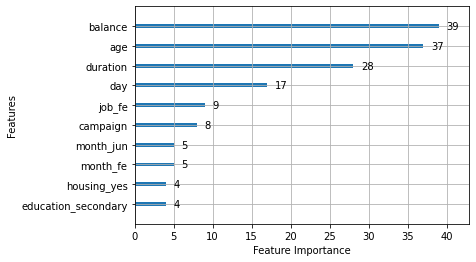

In [50]:
ax = lgb.plot_importance(lgb_model, max_num_features=10)
ax.set_title('')
ax.set_xlabel('Feature Importance')
ax.set_ylabel('Features')
plt.show()


In [53]:
y_submission_pred = lgb_model.predict(test1)
submission['y_bool'] = y_submission_pred

submission.to_csv("submission_1_lgbm.csv",index=False)

In [54]:
submission

,y_bool
0,0.255324
1,0.279162
2,0.267820
3,0.262080
4,0.282078
...,...
8995,0.255324
8996,0.275177
8997,0.263914
8998,0.266046
